In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json
from bs4 import BeautifulSoup
import lxml
import os

C:\Users\timothyelder\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [3]:
#loads sociology dataframe
soc_df = pd.read_pickle(r'C:\Users\timothyelder\Documents\final_project\soc_data\normalized_soc_df.pk1')


In [6]:
#first need to convert the documents into word count
#vectors 

#initialize
socCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#train
socVects = socCountVectorizer.fit_transform(soc_df['contents'])
print(socVects.shape)
#a matrix with row a document and each column a word
socVects

(4660, 23390)


<4660x23390 sparse matrix of type '<class 'numpy.int64'>'
	with 410818 stored elements in Compressed Sparse Row format>

In [7]:
#TF-IDF weighting 

#initialize
socTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(socVects)
#train
socTF = socTFTransformer.transform(socVects)
print(socTF.shape)

(4660, 23390)


In [8]:
#tf-idf for each word in each text
list(zip(socCountVectorizer.vocabulary_.keys(), socTF.data))[:20]

[('confidential', 0.10165767989273557),
 ('business', 0.07042443235081788),
 ('information', 0.037574190318827784),
 ('cbi', 0.31978501877749693),
 ('is', 0.04585515845233775),
 ('necessary', 0.05824897954760042),
 ('tool', 0.06230031925051906),
 ('to', 0.09381195206896714),
 ('protect', 0.13904404728302017),
 ('commercial', 0.20944637461329527),
 ('interests', 0.13118325952035373),
 ('in', 0.03932316783240637),
 ('the', 0.11262004998422333),
 ('rapidly', 0.05694305661093348),
 ('developing', 0.04595167540236532),
 ('field', 0.05354360200581896),
 ('of', 0.11220990694037333),
 ('gene', 0.06789601920273775),
 ('technology', 0.11190503044833779),
 ('also', 0.08954508278127879)]

In [9]:
#limit word vector to 1000 words with at least 3
#occurences 

#initialize
socTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
socTFVects = socTFVectorizer.fit_transform(soc_df['contents'])

In [11]:
socTFVects

<4660x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 164344 stored elements in Compressed Sparse Row format>

In [17]:
#displays vector for given word. 
try:
    print(socTFVectorizer.vocabulary_['information'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(socTFVectorizer.vocabulary_.keys())[:10]))

477


Considering the data I am using, it is difficult to set a number of clusters with a great deal of confidence. Considering that many of the sociology articles in plos seem to be about public health in general I think sociology about health with constitutue the largest cluster, and there is likely only one or two more clusters that would make sense. 

First, before doing K-Means clustering I am going to use the silhouette method to find the optimal number of clusters

In [43]:
#defines function for the silhouette method 
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

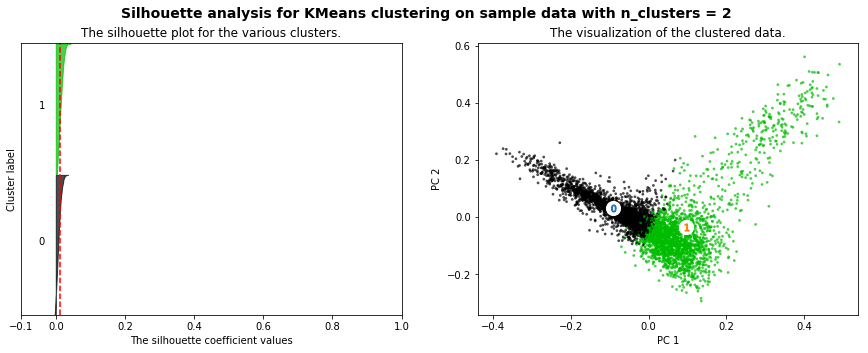

For n_clusters = 2, The average silhouette_score is : 0.011


In [44]:
X = socTFVects.toarray()
plotSilhouette(2, X)

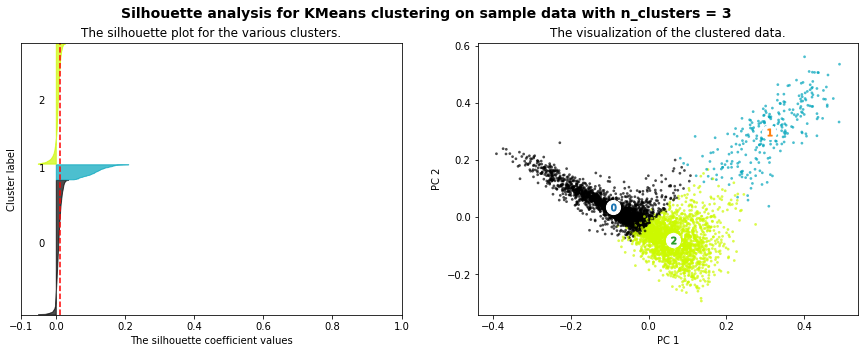

For n_clusters = 3, The average silhouette_score is : 0.012


In [45]:
X = socTFVects.toarray()
plotSilhouette(3, X)

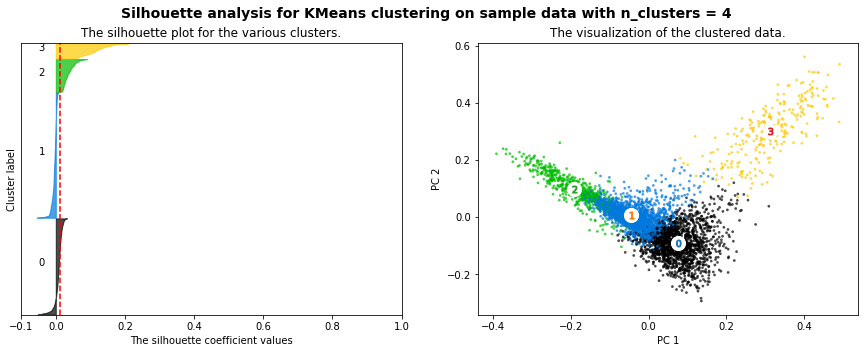

For n_clusters = 4, The average silhouette_score is : 0.011


In [46]:
X = socTFVects.toarray()
plotSilhouette(4, X)

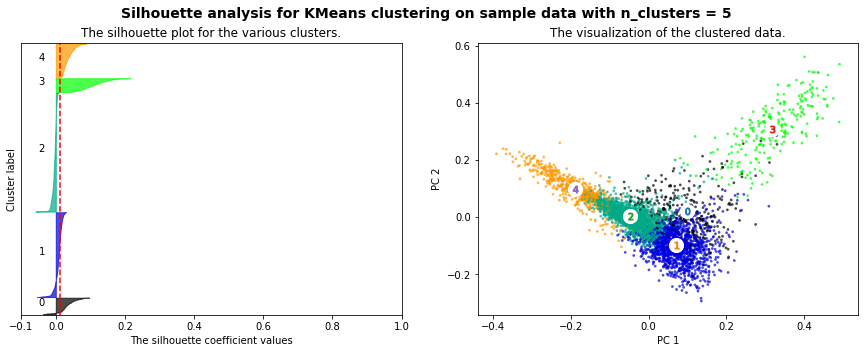

For n_clusters = 5, The average silhouette_score is : 0.012


In [47]:
X = socTFVects.toarray()
plotSilhouette(5, X)

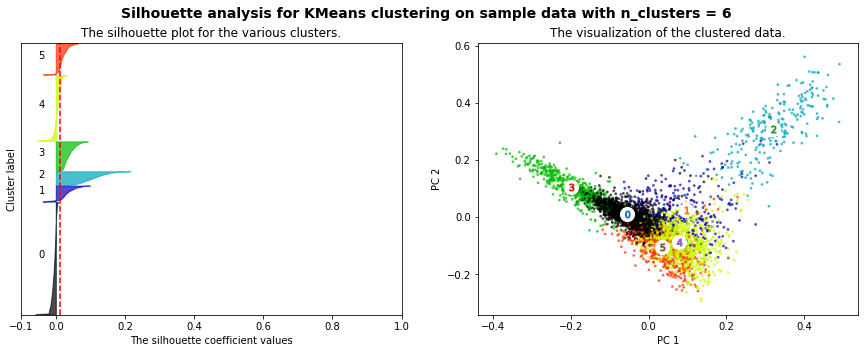

For n_clusters = 6, The average silhouette_score is : 0.013


In [48]:
X = socTFVects.toarray()
plotSilhouette(6, X)

In [31]:
numClusters = 3

In [32]:
#inititalize cluster finder

#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [33]:
#calculate clusters
km.fit(socTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [36]:
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(soc_df['contents'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(soc_df['contents'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(soc_df['contents'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(soc_df['contents'], km.labels_)))

Homogeneity: 0.103
Completeness: 1.000
V-measure: 0.187
Adjusted Rand Score: 0.000


In [37]:
#distinguishing features of the clusters

terms = socTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 social
 research
 networks
 information
 human
 network
 individuals
 data
 people
 studies


Cluster 1:
 hiv
 msm
 sex
 men
 infection
 aids
 risk
 infections
 africa
 women


Cluster 2:
 health
 children
 risk
 countries
 disease
 women
 care
 mortality
 patients
 population




In [38]:
#reduces dimensionality with PCA
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(socTFVects.toarray())
reduced_data = pca.transform(socTFVects.toarray())

In [41]:
PCA = sklearn.decomposition.PCA(n_components = 2).fit(socTFVects.toarray())
PCA_data = PCA.transform(socTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numClusters)))
colors_p = [colors[l] for l in km.labels_]

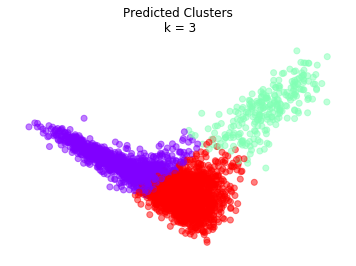

In [42]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(PCA_data[:, 0], PCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numClusters))
plt.show()

In [49]:
#assigning the predicted clusters to the dataframe 
soc_df['kmeans_predictions'] = km.labels_
soc_df

,contents,discipline,subjects,titles,year_publish,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,kmeans_predictions
0,Confidential business information (CBI) is a n...,sociology,"[perspective, biotechnology, biology, bioethic...",Biosafety Data as Confidential Business Inform...,2013,"[Confidential, business, information, (, CBI, ...",203,"[confidenti, busi, inform, cbi, necessari, too...",112,0
1,The scientific examination of how research is ...,sociology,"[mathematics, drug discovery, biology and life...",Meta-Research: Broadening the Scope of PLOS Bi...,2016,"[The, scientific, examination, of, how, resear...",53,"[scientif, examin, research, design, carri, co...",25,0
2,Both the scientific community and the general ...,sociology,"[biology and life sciences, community page, le...",Science Educational Outreach Programs That Ben...,2016,"[Both, the, scientific, community, and, the, g...",222,"[scientif, commun, gener, public, stand, benef...",110,0
3,Cooperative interactions between species (here...,sociology,"[plants, animals, plant physiology, plant scie...",Temporal Structure in Cooperative Interactions...,2016,"[Cooperative, interactions, between, species, ...",119,"[cooper, interact, speci, hereaft, mutual, ubi...",53,0
4,"In the past 20 years, the internet and social ...",sociology,"[social networks, social communication, scient...",A Guide to Scientific Crowdfunding,2016,"[In, the, past, 20, years, ,, the, internet, a...",246,"[past, year, internet, social, media, brought,...",123,0
5,"Recent, extensive meta-analysis of over a deca...",sociology,"[lectures, biology and life sciences, universi...",Peer-Led Team Learning Helps Minority Students...,2016,"[Recent, ,, extensive, meta-analysis, of, over...",108,"[recent, extens, decad, educ, research, ha, re...",57,0
6,"In the environmental sciences, the scientific ...",sociology,"[social communication, open science, perspecti...",Conservation Research Is Not Happening Where I...,2016,"[In, the, environmental, sciences, ,, the, sci...",66,"[environment, scienc, scientif, process, gener...",32,0
7,Data are the foundation of the scientific meth...,sociology,"[perspective, biology and life sciences, popul...",Gauging the Purported Costs of Public Data Arc...,2016,"[Data, are, the, foundation, of, the, scientif...",175,"[data, foundat, scientif, method, yet, individ...",90,0
8,“Plan for what is difficult while it is easy; ...,sociology,"[seeds, perspective, criminology, plant scienc...",Farewell to the Lose–Lose Reality of Policing ...,2016,"[“, Plan, for, what, is, difficult, while, it,...",27,"[plan, difficult, easi, great, tzu, art, war]",7,0
9,Stephen Jay Gould famously used the work of Sa...,sociology,"[africans, racial discrimination, musculoskele...","Morton, Gould, and Bias: A Comment on “The Mis...",2016,"[Stephen, Jay, Gould, famously, used, the, wor...",159,"[stephen, jay, gould, famous, use, work, samue...",85,0


In [64]:
count = 0 
for i in soc_df['kmeans_predictions']:
    if i == 0:
        count = count + 1

In [65]:
count

2316

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 